# Gas fees during inscriptions - EDA

#### Maria Silva, April 2024


In [1]:
import os
import sys
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "dune_export"))
plot_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "plots"))
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

In [3]:
sys.path.append(code_dir)

from plot_utils import get_plotly_layout
from plot_utils import colors
width, height = 700, 450

## Load data

### Arbitrum

In [4]:
arb_file = os.path.join(data_dir, "arbitrum_gas_data_part1.csv")
# Fix columns name: avg_gas_price_gwei
arb_df = pd.read_csv(arb_file)
arb_df["block_time"] = pd.to_datetime(arb_df["block_time"])
arb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18821360 entries, 0 to 18821359
Data columns (total 15 columns):
 #   Column                   Dtype              
---  ------                   -----              
 0   avg_gas_price_qwei       float64            
 1   avg_l1_fee_eth           float64            
 2   avg_l2_fee_eth           float64            
 3   avg_tx_fee_eth           float64            
 4   block_number             int64              
 5   block_time               datetime64[ns, UTC]
 6   total_calldata_gas_used  int64              
 7   total_data_length        int64              
 8   total_gas_used           int64              
 9   total_gas_used_for_l1    int64              
 10  total_gas_used_for_l2    int64              
 11  total_l1_fee_eth         float64            
 12  total_l2_fee_eth         float64            
 13  total_tx_fee_eth         float64            
 14  transactions             int64              
dtypes: datetime64[ns, UTC](1), flo

In [5]:
arb_df["block_time"].agg(["min", "max"])

min   2023-11-15 00:00:00+00:00
max   2024-01-11 23:41:07+00:00
Name: block_time, dtype: datetime64[ns, UTC]

### zksync

In [6]:
zks_file = os.path.join(data_dir, "zksync_gas_data.csv")
zks_df = pd.read_csv(zks_file)
zks_df["batch_time"] = pd.to_datetime(zks_df["batch_time"])
zks_df = zks_df[zks_df["batch_time"]<"2024-02-01"]
zks_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112095 entries, 0 to 112094
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   avg_gas_price_gwei               112095 non-null  float64            
 1   avg_l1_fee_eth                   112095 non-null  float64            
 2   avg_l2_fee_eth                   112095 non-null  float64            
 3   avg_tx_fee_eth                   112095 non-null  float64            
 4   l1_batch_number                  112095 non-null  float64            
 5   l1_gas_price_for_commit_gwei     112095 non-null  float64            
 6   l1_gas_price_for_execute_gwei    112095 non-null  float64            
 7   l1_gas_price_for_prove_gwei      112095 non-null  float64            
 8   batch_time                       112095 non-null  datetime64[ns, UTC]
 9   total_calldata_gas_used_on_l1    112095 non-null  float64       

In [7]:
zks_df["batch_time"].agg(["min", "max"])

min   2023-11-15 00:01:19+00:00
max   2024-01-31 23:59:28+00:00
Name: batch_time, dtype: datetime64[ns, UTC]

## Daily stats

In [8]:
arb_sum_df = (
    arb_df
    .groupby(pd.Grouper(key="block_time", freq="D"))
    .sum()
    .reset_index()
)
arb_sum_df["day"] = arb_sum_df["block_time"]

zks_sum_df = (
    zks_df
    .groupby(pd.Grouper(key="batch_time", freq="D"))
    .sum()
    .reset_index()
)
zks_sum_df["day"] = zks_sum_df["batch_time"]

### Total transaction fees

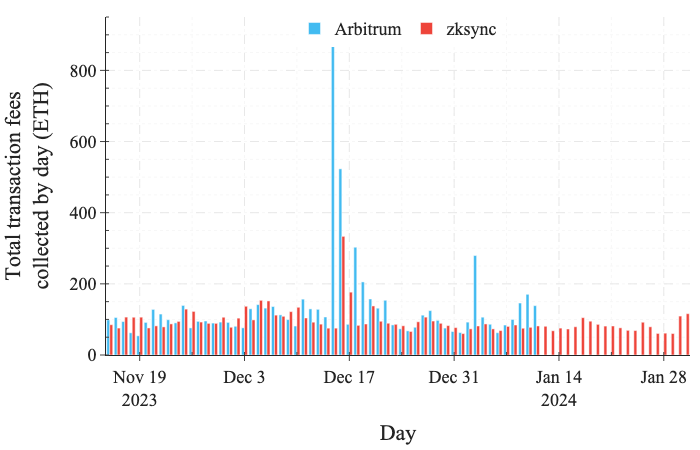

In [9]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(
    go.Bar(
        x=arb_sum_df["block_time"],
        y=arb_sum_df["total_tx_fee_eth"],
        marker_color=colors["blue"],
        name="Arbitrum",
    )
)
fig.add_trace(
    go.Bar(
        x=zks_sum_df["batch_time"],
        y=zks_sum_df["total_tx_fee_eth"],
        marker_color=colors["red"],
        name="zksync",
    )
)
fig.update_layout(
    yaxis_title="Total transaction fees<br>collected by day (ETH)",
    xaxis_title="Day",
    legend=dict(xanchor="center", x=0.5, y=1.02, orientation="h"),
)

fig.write_image(os.path.join(plot_dir, "eda_total_tx_fee_eth.png"),scale=5)
fig.show("png")

### Average fee per transaction

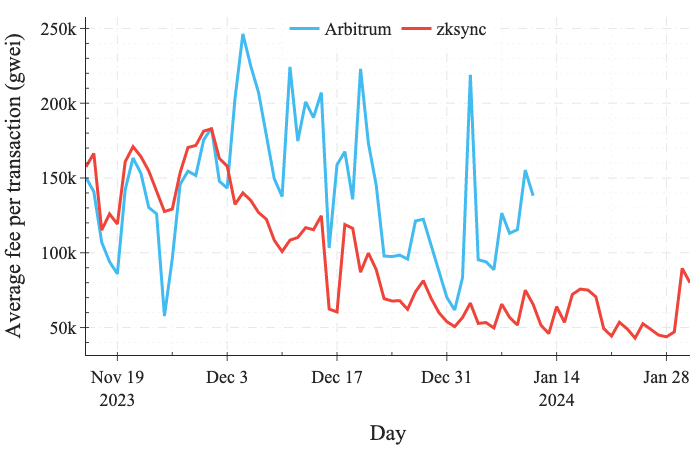

In [10]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(
    go.Scatter(
        x=arb_sum_df["block_time"],
        y=(arb_sum_df["total_tx_fee_eth"]/arb_sum_df["transactions"])*1e9,
        line=dict(color=colors["blue"], width=3, dash="solid"),
        mode="lines",
        name="Arbitrum",
    )
)
fig.add_trace(
    go.Scatter(
        x=zks_sum_df["batch_time"],
        y=(zks_sum_df["total_tx_fee_eth"]/zks_sum_df["transactions"])*1e9,
        line=dict(color=colors["red"], width=3, dash="solid"),
        mode="lines",
        name="zksync",
    )
)
fig.update_layout(
    yaxis_title="Average fee per transaction (gwei)",
    xaxis_title="Day",
    legend=dict(xanchor="center", x=0.5, y=1.02, orientation="h"),
)

fig.write_image(os.path.join(plot_dir, "eda_avg_tx_fee_eth.png"),scale=5)
fig.show("png")

### Total gas used

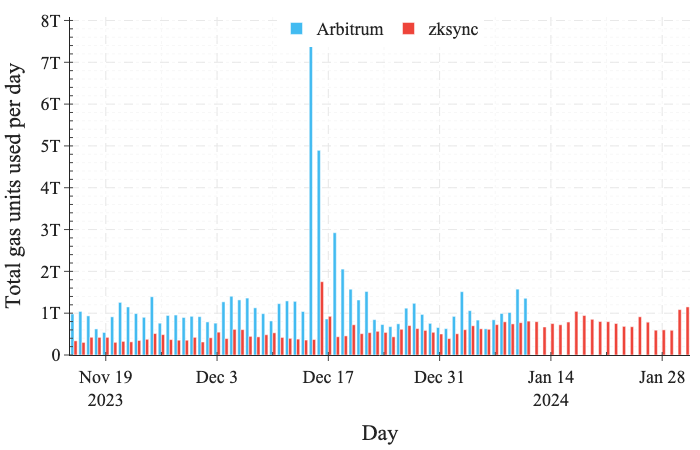

In [11]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(
    go.Bar(
        x=arb_sum_df["block_time"],
        y=arb_sum_df["total_gas_used"],
        marker_color=colors["blue"],
        name="Arbitrum",
    )
)
fig.add_trace(
    go.Bar(
        x=zks_sum_df["batch_time"],
        y=zks_sum_df["total_gas_used"],
        marker_color=colors["red"],
        name="zksync",
    )
)
fig.update_layout(
    yaxis_title="Total gas units used per day",
    xaxis_title="Day",
    legend=dict(xanchor="center", x=0.5, y=1.02, orientation="h"),
)

fig.write_image(os.path.join(plot_dir, "eda_gas_used.png"),scale=5)
fig.show("png")

### No. of transactions

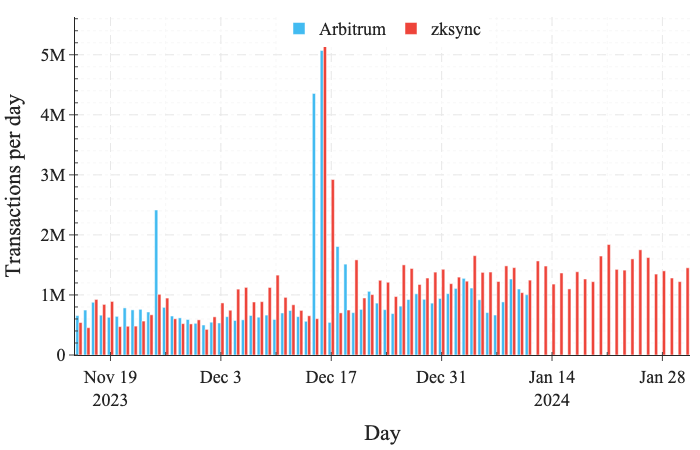

In [12]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(
    go.Bar(
        x=arb_sum_df["block_time"],
        y=arb_sum_df["transactions"],
        marker_color=colors["blue"],
        name="Arbitrum",
    )
)
fig.add_trace(
    go.Bar(
        x=zks_sum_df["batch_time"],
        y=zks_sum_df["transactions"],
        marker_color=colors["red"],
        name="zksync",
    )
)
fig.update_layout(
    yaxis_title="Transactions per day",
    xaxis_title="Day",
    legend=dict(xanchor="center", x=0.5, y=1.02, orientation="h"),
)

fig.write_image(os.path.join(plot_dir, "eda_txs.png"),scale=5)
fig.show("png")

## Weekly stats

In [13]:
arb_sum_df = (
    arb_df
    .groupby(pd.Grouper(key="block_time", freq="W"))
    .sum()
    .reset_index()
)
arb_sum_df["day"] = arb_sum_df["block_time"]

zks_sum_df = (
    zks_df
    .groupby(pd.Grouper(key="batch_time", freq="W"))
    .sum()
    .reset_index()
)
zks_sum_df["day"] = zks_sum_df["batch_time"]

### Total transaction fees - L1/L2

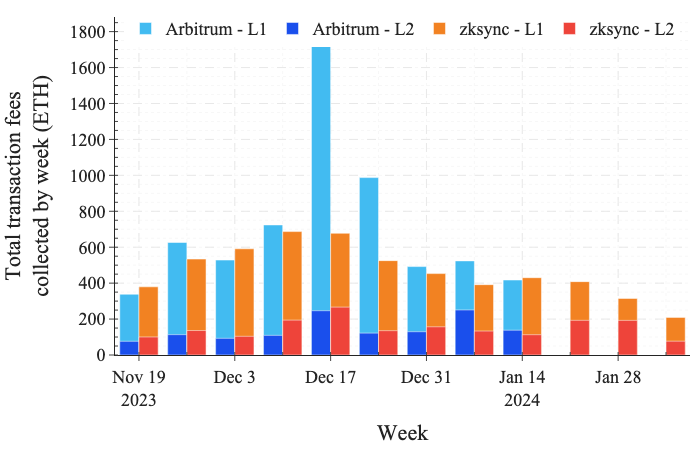

In [14]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(
    go.Bar(
        x=arb_sum_df["block_time"],
        y=arb_sum_df["total_l1_fee_eth"],
        marker_color=colors["blue"],
        name="Arbitrum - L1",
        offsetgroup=0,
    )
)
fig.add_trace(
    go.Bar(
        x=arb_sum_df["block_time"],
        y=arb_sum_df["total_l2_fee_eth"],
        marker_color=colors["dark_blue"],
        name="Arbitrum - L2",
        offsetgroup=0,
    )
)
fig.add_trace(
    go.Bar(
        x=zks_sum_df["batch_time"],
        y=zks_sum_df["total_l1_fee_eth"],
        marker_color=colors["orange"],
        name="zksync - L1",
        offsetgroup=1,
    )
)
fig.add_trace(
    go.Bar(
        x=zks_sum_df["batch_time"],
        y=zks_sum_df["total_l2_fee_eth"],
        marker_color=colors["red"],
        name="zksync - L2",
        offsetgroup=1,
    )
)
fig.update_layout(
    yaxis_title="Total transaction fees<br>collected by week (ETH)",
    xaxis_title="Week",
    legend=dict(xanchor="center", x=0.5, y=1.02, orientation="h"),
)

fig.write_image(os.path.join(plot_dir, "eda_l1vl2_tx_fee_eth.png"),scale=5)
fig.show("png")

## Correlations

### Arbitrum

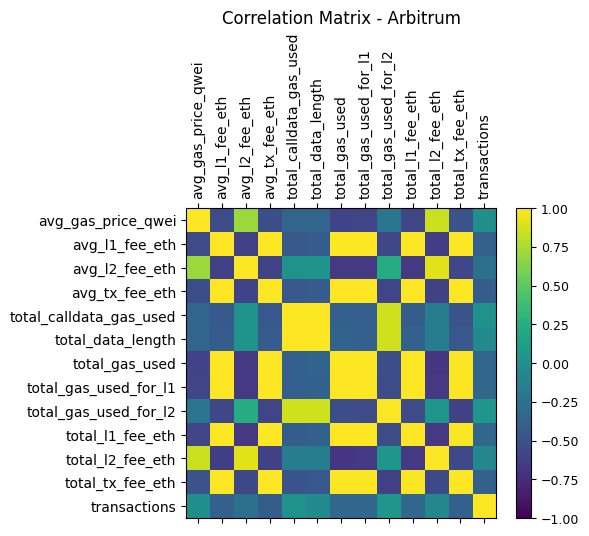

In [15]:
temp_df = arb_df.drop(columns=['block_number', 'block_time']).corr()
f = plt.figure(figsize=(5, 4))
plt.matshow(temp_df.corr(), fignum=f.number, vmin=-1, vmax=1)
plt.xticks(range(temp_df.shape[1]), temp_df.columns, fontsize=10, rotation=90)
plt.yticks(range(temp_df.shape[1]), temp_df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=9)
plt.title('Correlation Matrix - Arbitrum', fontsize=12)
plt.show()

### zksync

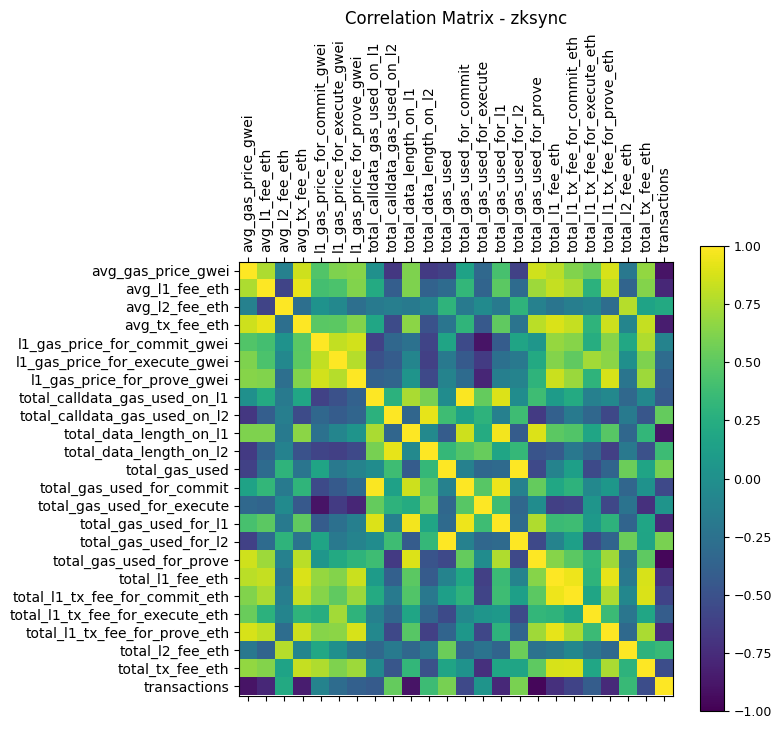

In [19]:
temp_df = zks_df.drop(columns=['l1_batch_number', 'batch_time']).corr()
f = plt.figure(figsize=(7, 6))
plt.matshow(temp_df.corr(), fignum=f.number, vmin=-1, vmax=1)
plt.xticks(range(temp_df.shape[1]), temp_df.columns, fontsize=10, rotation=90)
plt.yticks(range(temp_df.shape[1]), temp_df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=9)
plt.title('Correlation Matrix - zksync', fontsize=12)
plt.show()